In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >="2016-08-23").\
                order_by(Measurement.date).all()
precipitation_df = pd.DataFrame(precipitation)
precipitation_df = precipitation_df.set_index("date")
precipitation_df 

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


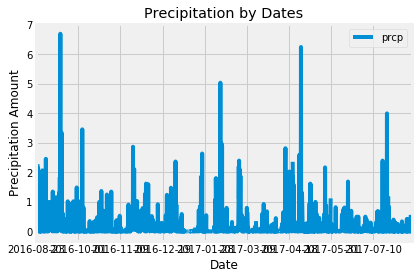

In [11]:
# Plot the results using the DataFrame `plot` method
precipitation_df.plot()
plt.title("Precipitation by Dates")
plt.xlabel("Date")
plt.ylabel("Precipitation Amount")

plt.savefig("precipitation.png")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
stations_count

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = "USC00519281"
station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).all()
station_stats

[(54.0, 85.0, 71.66378066378067)]

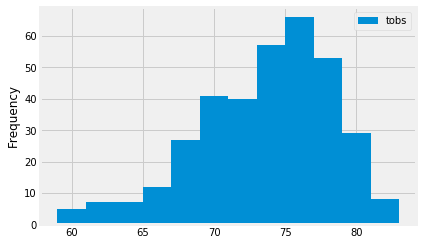

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_stats = session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.date >="2016-08-23").\
                            filter(Measurement.date).\
                            filter(Measurement.station == most_active_station).all()

most_active_station_stats_df = pd.DataFrame(most_active_station_stats)
most_active_station_stats_df = most_active_station_stats_df.set_index("date")
most_active_station_stats_df 

fig, ax = plt.subplots()
most_active_station_stats_df.plot.hist(bins = 12, ax = ax)

plt.savefig("histogram.png")

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
## trip_dates = 2014-08-05 to 2014-08-12
trip_dates = calc_temps('2013-08-05', '2013-08-12')
trip_dates

[(68.0, 75.61666666666666, 82.0)]

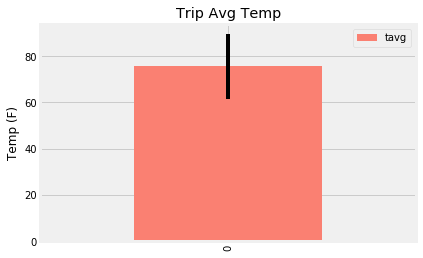

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_dates_df = pd.DataFrame(trip_dates, columns = ['tmin', 'tavg', 'tmax'])
trip_dates_df

trip_dates_df.plot.bar(y="tavg", yerr=(trip_dates_df['tmax']-trip_dates_df["tmin"]), color='salmon')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

plt.savefig("tripavgtemp.png")

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_dates = calc_temps('2013-08-05', '2013-08-12')

start_date = '2013-08-05'
end_date = '2013-08-12'

rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Station.name).\
            order_by(func.sum(Measurement.prcp).desc()).all()

rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.3100000000000005),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.55),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.05),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.0999999999999996),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.07),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.03),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2013-08-05'
end_date = '2013-08-12'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
month_days = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
listdate = []
for x in month_days:
    listdate.append(*daily_normals(x))

listdate

[(69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
listdate_df = pd.DataFrame(listdate, columns=["tmin", "tavg", "tmax"])

# add column to data frame
listdate_df["date_range"] = date_range

# reset index to date_range
listdate_df = listdate_df.set_index('date_range')
listdate_df

,tmin,tavg,tmax
date_range,,,
2013-08-05,69.0,76.148148,82.0
2013-08-06,67.0,76.250000,83.0
2013-08-07,71.0,77.156863,83.0
2013-08-08,68.0,76.557692,83.0
2013-08-09,69.0,75.980392,81.0
2013-08-10,65.0,76.420000,83.0
2013-08-11,67.0,75.981132,82.0
2013-08-12,67.0,76.527273,83.0


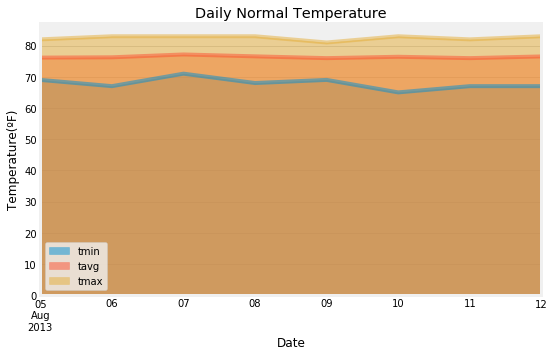

In [24]:
# Plot the daily normals as an area plot with `stacked=False`

listdate_df.plot.area(stacked=False, figsize = (8,5))
#listdate_df.plot(kind='area', stacked=False, figsize = (8,5))
plt.title("Daily Normal Temperature")
plt.ylabel("Temperature(ºF)")
plt.xlabel("Date")

plt.savefig("areaplot.png")